In [2]:
import os
import sys
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("YourAppName")  \
    .config("spark.executor.memory", "6g") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

merchants = spark.read.parquet("../data/curated/curated_merchants")
merchants = merchants.drop("name", "rev_level", "take_rate")
merchants.show(3)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/07 23:05:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/07 23:05:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+------------+--------------------+
|merchant_abn|                type|
+------------+--------------------+
| 10023283211|furniture, home f...|
| 10142254217|cable, satellite,...|
| 10187291046|watch, clock, and...|
+------------+--------------------+
only showing top 3 rows



In [3]:
import nltk
from pyspark.sql.functions import udf, split
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.types import StringType
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Download NLTK stopwords and WordNet data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') 

# Preprocessing function
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(x):
    if x:
        # Lowercase the text
        x = x.lower()
        # Remove punctuation
        x = x.translate(str.maketrans('', '', string.punctuation))
        # Lemmatize words
        x = " ".join([lemmatizer.lemmatize(word) for word in x.split()])
        # Remove stop words
        x = ' '.join([word for word in x.split() if word not in STOPWORDS])
    return x

# Register as UDF (User Defined Function)
preprocess_udf = udf(preprocess_text, StringType())

# Read the merchant data
merchants = spark.read.parquet("../data/curated/curated_merchants")

# Apply preprocessing to 'type' column
merchants_cleaned = merchants.withColumn("type_clean", preprocess_udf(merchants['type']))

# Convert the `type_clean` column to an array of words (necessary for CountVectorizer)
merchants_cleaned = merchants_cleaned.withColumn("type_clean", split(merchants_cleaned["type_clean"], " "))

# Now apply CountVectorizer for one-hot encoding
vectorizer = CountVectorizer(inputCol="type_clean", outputCol="type_encoded", binary=True)
vectorized_model = vectorizer.fit(merchants_cleaned)
merchants_vectorized = vectorized_model.transform(merchants_cleaned)

# Show final output
merchants_vectorized.select('merchant_abn', 'type_clean', 'type_encoded').show(truncate=False)

24/10/07 23:06:08 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
[nltk_data] Downloading package stopwords to /Users/ngoc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ngoc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ngoc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


+------------+-------------------------------------------------------------------------------+--------------------------------------------------------------+
|merchant_abn|type_clean                                                                     |type_encoded                                                  |
+------------+-------------------------------------------------------------------------------+--------------------------------------------------------------+
|10023283211 |[furniture, home, furnishing, equipment, shop, manufacturer, except, appliance]|(87,[0,5,9,10,27,30,31,33],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|10142254217 |[cable, satellite, pay, television, radio, service]                            |(87,[2,42,43,44,45,46],[1.0,1.0,1.0,1.0,1.0,1.0])             |
|10187291046 |[watch, clock, jewelry, repair, shop]                                          |(87,[0,12,13,14,15],[1.0,1.0,1.0,1.0,1.0])                    |
|10192359162 |[music, shop, musical, instrument, pia

In [4]:
# Obtain the vocabulary from the CountVectorizer model
vocabulary = vectorized_model.vocabulary

# Extract both 'merchant_abn' and 'type_encoded' (dense vector)
merchant_data = merchants_vectorized.select("merchant_abn", "type_encoded").rdd.map(lambda row: (row.merchant_abn, row.type_encoded.toArray())).collect()

# Create separate lists for 'merchant_abn' and the dense vectors
merchant_abn_list = [row[0] for row in merchant_data]
dense_vectors = [row[1] for row in merchant_data]

# Create a DataFrame for the dense vectors (with columns as vocabulary)
dense_df = pd.DataFrame(dense_vectors, columns=vocabulary)

# Add the 'merchant_abn' column to the DataFrame
dense_df['merchant_abn'] = merchant_abn_list

# Drop the words as they are too general or business related
words_to_drop = ['shop', 'service', 'supply', 'sale']
dense_df = dense_df.drop(columns=[word for word in words_to_drop if word in dense_df.columns])

# Show the resulting DataFrame
dense_df.head()

,computer,music,equipment,book,good,nursery,appliance,furniture,repair,jewelry,...,leasing,al,telecom,gallery,dealer,art,antique,restoration,silverware,merchant_abn
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10023283211
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10142254217
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10187291046
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10192359162
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10206519221


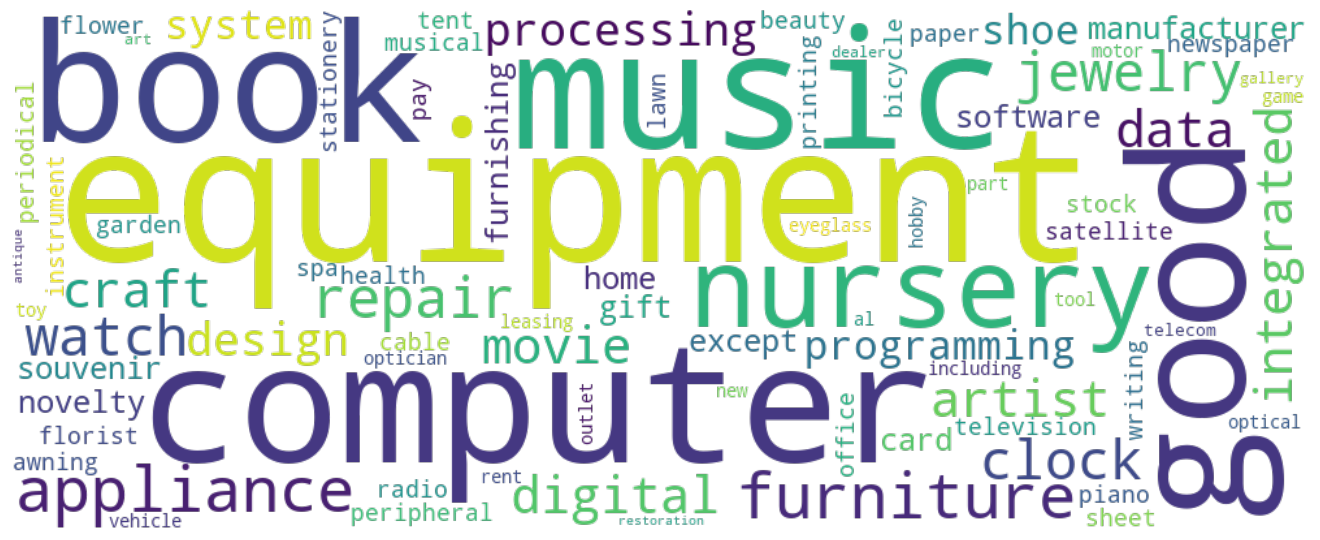

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert dense_df to a DataFrame suitable for word cloud creation
# Sum up all columns except the 'merchant_abn' to get word frequencies
word_frequencies = dense_df.drop('merchant_abn', axis=1).sum()

# Convert to dictionary format for WordCloud
word_freq_dict = word_frequencies.to_dict()

# Create and plot the WordCloud image
wordcloud = WordCloud(mode="RGBA", width=1000, height=400, 
                      background_color=None, min_font_size=10).generate_from_frequencies(word_freq_dict)

# Plotting
fig, ax = plt.subplots(1, figsize=(13, 9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# Assuming dense_df is already created and contains merchant_abn and the dense word vectors
df = dense_df.drop('merchant_abn', axis=1)  # Drop 'merchant_abn' for clustering, keep only word vectors

# Number of clusters 
n_clusters = 25

# Fit K-Means clustering
km = KMeans(n_clusters=n_clusters, random_state=0)
km.fit(df)

# Add the cluster labels to the DataFrame
dense_df['cluster_num'] = km.labels_

# Create final DataFrame with 'merchant_abn' and 'cluster_num'
final_df = dense_df[['merchant_abn', 'cluster_num']]

# Show the final DataFrame
print(final_df)

      merchant_abn  cluster_num
0      10023283211            2
1      10142254217            4
2      10187291046            7
3      10192359162            8
4      10206519221           10
...            ...          ...
3925   99938978285           12
3926   99974311662           17
3927   99976658299           21
3928   99987905597           13
3929   99990536339           13

[3930 rows x 2 columns]


In [7]:
# Group by 'cluster_num' and sum the one-hot encoded word vectors to get word frequencies
cluster_word_freq = dense_df.drop('merchant_abn', axis=1).groupby('cluster_num').sum()

# Transpose the DataFrame for better readability (clusters as rows, words as columns)
cluster_word_freq = cluster_word_freq.T

# Show the most common words in each cluster
for cluster in cluster_word_freq.columns:
    print(f"\nMost common words in cluster {cluster}:")
    top_words = cluster_word_freq[cluster].sort_values(ascending=False).head(10)
    print(top_words)


Most common words in cluster 0:
outlet        153.0
including     153.0
lawn          153.0
garden        153.0
nursery       153.0
newspaper       0.0
office          0.0
stationery      0.0
printing        0.0
writing         0.0
Name: 0, dtype: float64

Most common words in cluster 1:
health        164.0
beauty        164.0
spa           164.0
computer        0.0
writing         0.0
including       0.0
lawn            0.0
garden          0.0
office          0.0
stationery      0.0
Name: 1, dtype: float64

Most common words in cluster 2:
manufacturer    182.0
equipment       182.0
except          182.0
furnishing      182.0
appliance       182.0
furniture       182.0
home            182.0
stationery        0.0
outlet            0.0
including         0.0
Name: 2, dtype: float64

Most common words in cluster 3:
telecom       120.0
computer        0.0
newspaper       0.0
including       0.0
lawn            0.0
garden          0.0
office          0.0
stationery      0.0
printing        

In [8]:
# Count number of merchants in each cluster_num
cluster_counts = final_df['cluster_num'].value_counts()
print("Number of merchants in each cluster:")
print(cluster_counts)

Number of merchants in each cluster:
cluster_num
9     195
15    193
5     190
21    185
2     182
10    182
16    181
11    180
19    178
4     175
7     170
22    170
8     167
1     164
17    164
14    161
0     153
12    151
13    147
18    142
6     133
3     120
20    107
23     80
24     60
Name: count, dtype: int64


### Using domain knowledge of products, we will rename and segment (0, 2, 6) as housing applicances and furnishings, (1, 12) as health and beauty, (8, 9, 11, 15, 20, 23) as art and decors, (7, 21, 24) for accessories and luxuries , (3, 4, 5, 16) for IT and tech gadgets, 10 as sourvenirs and gifts, 14 as office equipment, (13, 22) as transportation, (17, 18, 19) as leisure and hobbies

In [9]:
# Grouping by 'cluster_num' and renaming based on provided domain knowledge
cluster_mapping = {
    0: "Housing Appliances and Furnishings",
    2: "Housing Appliances and Furnishings",
    6: "Housing Appliances and Furnishings",
    1: "Health and Beauty",
    12: "Health and Beauty",
    8: "Art and Decors",
    9: "Art and Decors",
    11: "Art and Decors",
    15: "Art and Decors",
    20: "Art and Decors",
    23: "Art and Decors",
    7: "Accessories and Luxuries",
    21: "Accessories and Luxuries",
    24: "Accessories and Luxuries",
    3: "IT and Tech Gadgets",
    4: "IT and Tech Gadgets",
    5: "IT and Tech Gadgets",
    16: "IT and Tech Gadgets",
    10: "Souvenirs and Gifts",
    14: "Office Equipment",
    13: "Transportation",
    22: "Transportation",
    17: "Leisure and Hobbies",
    18: "Leisure and Hobbies",
    19: "Leisure and Hobbies"
}

# Apply the mapping to rename 'cluster_num' to meaningful 'cluster' names
final_df['cluster'] = final_df['cluster_num'].map(cluster_mapping)

# Drop the old 'cluster_num' column if no longer needed
final_df = final_df.drop(columns=['cluster_num'])

# Count the number of merchants in each renamed cluster
merchant_count_by_cluster = final_df['cluster'].value_counts()

# Show the final counts for each cluster
print(merchant_count_by_cluster)


cluster
Art and Decors                        922
IT and Tech Gadgets                   666
Leisure and Hobbies                   484
Housing Appliances and Furnishings    468
Accessories and Luxuries              415
Transportation                        317
Health and Beauty                     315
Souvenirs and Gifts                   182
Office Equipment                      161
Name: count, dtype: int64


/var/folders/1_/_q5ybns967q36gtt1tq4b6dw0000gn/T/ipykernel_35618/3688161663.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['cluster'] = final_df['cluster_num'].map(cluster_mapping)


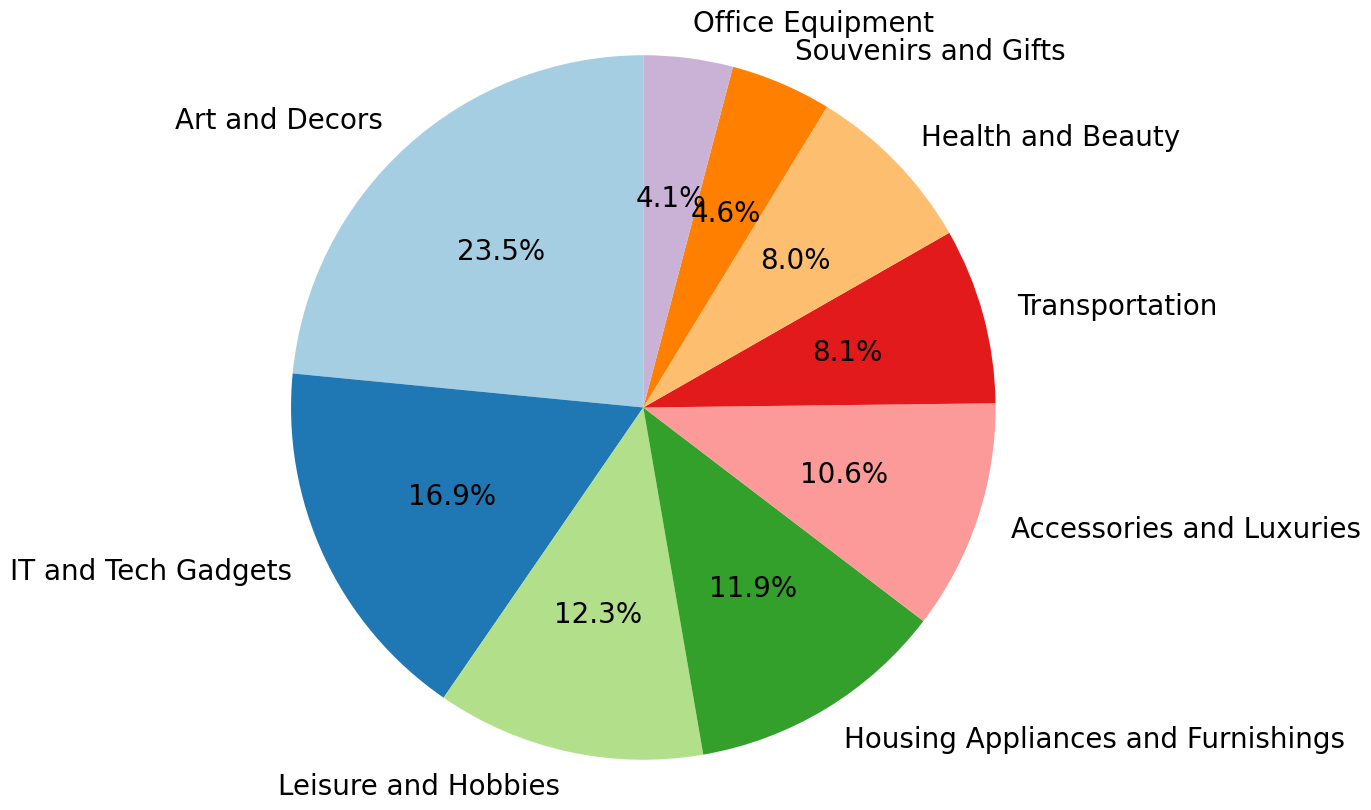

In [18]:
import matplotlib.pyplot as plt

# Prepare data for the pie chart
labels = merchant_count_by_cluster.index
sizes = merchant_count_by_cluster.values

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors, 
        textprops={'fontsize': 20})

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()

In [11]:
print(final_df)

      merchant_abn                             cluster
0      10023283211  Housing Appliances and Furnishings
1      10142254217                 IT and Tech Gadgets
2      10187291046            Accessories and Luxuries
3      10192359162                      Art and Decors
4      10206519221                 Souvenirs and Gifts
...            ...                                 ...
3925   99938978285                   Health and Beauty
3926   99974311662                 Leisure and Hobbies
3927   99976658299            Accessories and Luxuries
3928   99987905597                      Transportation
3929   99990536339                      Transportation

[3930 rows x 2 columns]


In [12]:
transactions = spark.read.parquet("../data/curated/curated_transaction")

In [13]:
transactions.head(3)

[Row(user_id=14935, merchant_abn=79417999332, dollar_value=136.06570809815838, order_id='23acbb7b-cf98-4580-9775-86b8e0a2bd88', order_datetime=datetime.date(2021, 11, 26), log_dollar_value=4.91313791683832),
 Row(user_id=1, merchant_abn=46451548968, dollar_value=72.61581642788431, order_id='76bab304-fa2d-4004-8179-8638b56a873e', order_datetime=datetime.date(2021, 11, 26), log_dollar_value=4.285182755236724),
 Row(user_id=14936, merchant_abn=89518629617, dollar_value=3.0783487174439297, order_id='a2ae446a-2959-41c4-81fd-a30c1efbde0c', order_datetime=datetime.date(2021, 11, 26), log_dollar_value=1.124393322516008)]

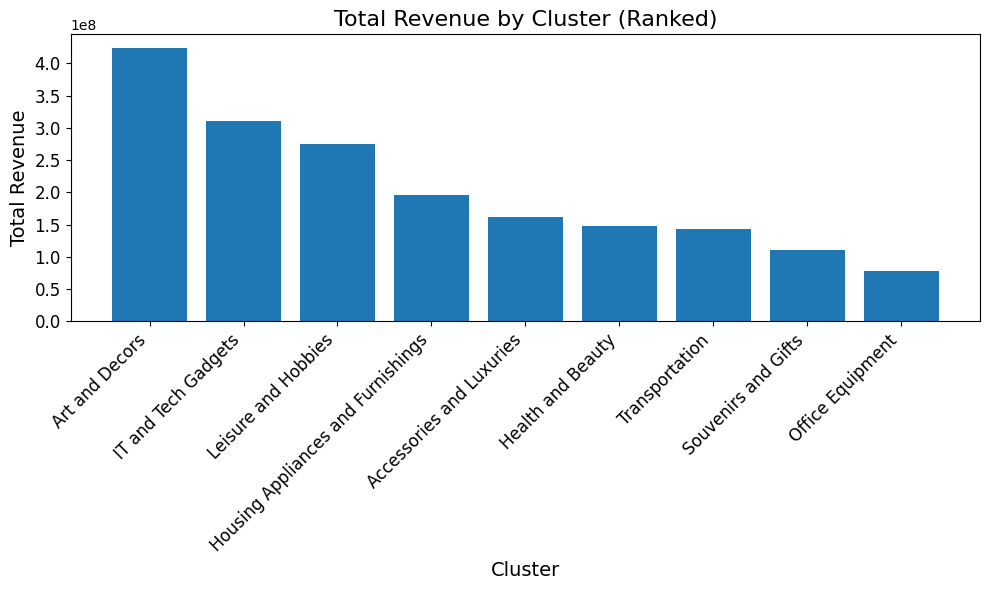

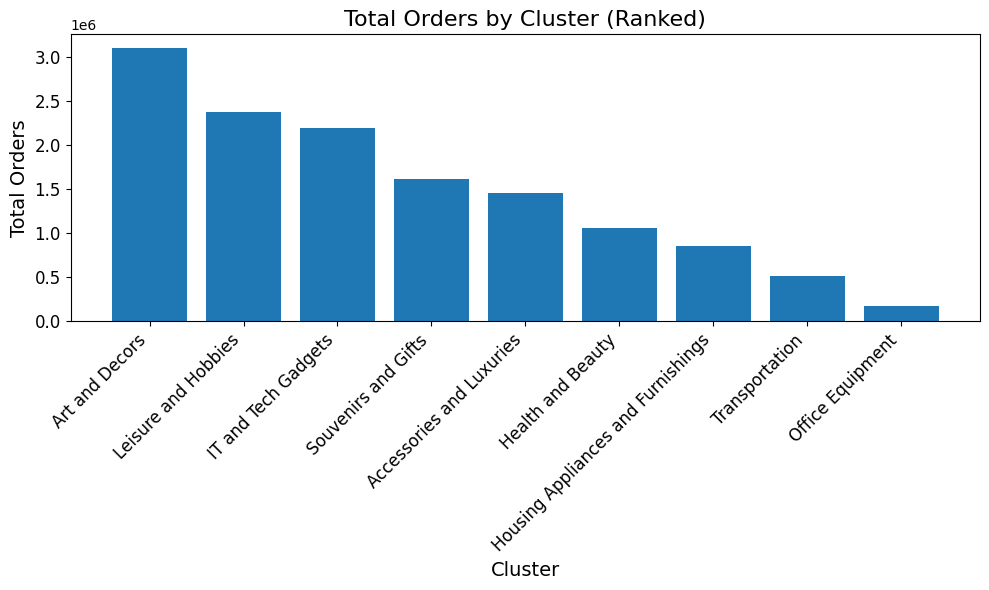

In [14]:
from pyspark.sql import functions as F

# Convert final_df to a Spark DataFrame if it's in Pandas
final_df_spark = spark.createDataFrame(final_df)

# Group by merchant_abn to calculate total revenue and number of transactions for each merchant
merchant_summary = transactions.groupBy('merchant_abn').agg(
    F.sum('dollar_value').alias('total_revenue'),
    F.count('order_id').alias('transaction_count')
)

# Join the merchant summary with the final_df that contains cluster information
merchant_cluster_summary = merchant_summary.join(final_df_spark, on='merchant_abn', how='inner')

# Group by cluster to calculate total revenue and total number of transactions for each cluster
cluster_summary = merchant_cluster_summary.groupBy('cluster').agg(
    F.sum('total_revenue').alias('total_revenue_by_cluster'),
    F.sum('transaction_count').alias('total_orders_by_cluster')
)

# Convert PySpark DataFrame to Pandas DataFrame for sorting and plotting
cluster_summary_pd = cluster_summary.toPandas()

# Sort by total revenue (high to low)
cluster_summary_pd = cluster_summary_pd.sort_values(by='total_revenue_by_cluster', ascending=False)

# Plot total revenue by cluster (ranked high to low)
plt.figure(figsize=(10, 6))
plt.bar(cluster_summary_pd['cluster'], cluster_summary_pd['total_revenue_by_cluster'])
plt.xlabel('Cluster', fontsize=14)  # Increase label size
plt.ylabel('Total Revenue', fontsize=14)  # Increase label size
plt.title('Total Revenue by Cluster (Ranked)', fontsize=16)  # Increase title size
plt.xticks(rotation=45, ha="right", fontsize=12)  # Increase x-tick size
plt.yticks(fontsize=12)  # Increase y-tick size
plt.tight_layout()
plt.show()

# Sort by total orders (high to low)
cluster_summary_pd = cluster_summary_pd.sort_values(by='total_orders_by_cluster', ascending=False)

# Plot total orders by cluster (ranked high to low)
plt.figure(figsize=(10, 6))
plt.bar(cluster_summary_pd['cluster'], cluster_summary_pd['total_orders_by_cluster'])
plt.xlabel('Cluster', fontsize=14)  # Increase label size
plt.ylabel('Total Orders', fontsize=14)  # Increase label size
plt.title('Total Orders by Cluster (Ranked)', fontsize=16)  # Increase title size
plt.xticks(rotation=45, ha="right", fontsize=12)  # Increase x-tick size
plt.yticks(fontsize=12)  # Increase y-tick size
plt.tight_layout()
plt.show()


In [15]:
# Read all Parquet files from the directory
profit_df = spark.read.parquet(os.path.join("../data/curated/cleaned_profit_per_merchants", "*.parquet"))

# Show the result
profit_df.show(3)

+------------+-----------------------------+
|merchant_abn|predict_6_months_total_profit|
+------------+-----------------------------+
| 10255988167|                    4401.4478|
| 10430380319|                     1007.187|
| 11215815177|                    18600.148|
+------------+-----------------------------+
only showing top 3 rows



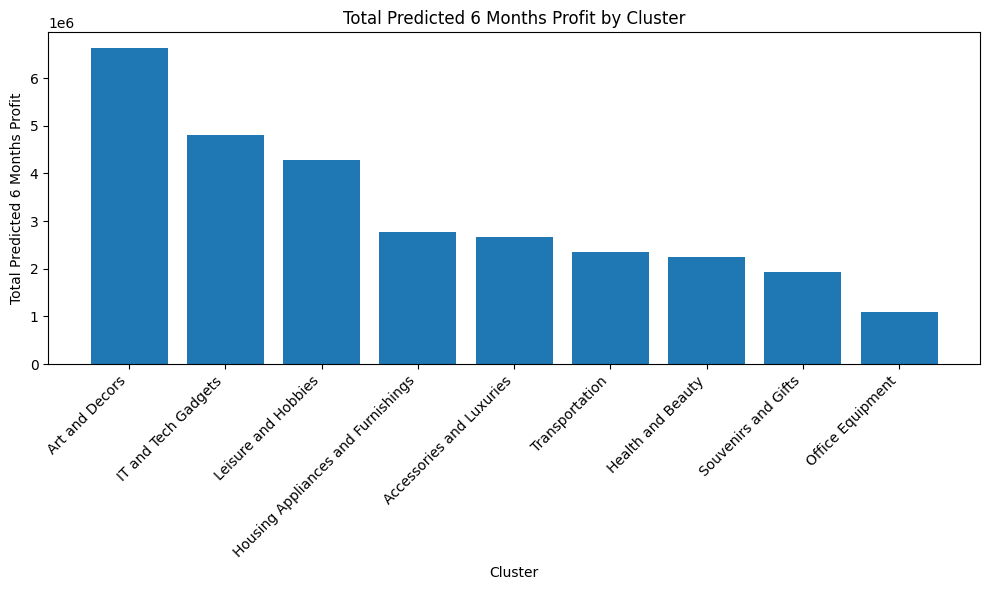

In [16]:
# Join profit_df with final_df_spark to get the cluster information
profit_with_cluster = profit_df.join(final_df_spark, on='merchant_abn', how='inner')

# Group by cluster to calculate the total predicted 6 months profit by cluster
cluster_profit_summary = profit_with_cluster.groupBy('cluster').agg(
    F.sum('predict_6_months_total_profit').alias('total_predicted_profit')
)

# Convert to Pandas for plotting
cluster_profit_summary_pd = cluster_profit_summary.toPandas()

# Sort by total predicted profit (high to low) for better visualization
cluster_profit_summary_pd = cluster_profit_summary_pd.sort_values(by='total_predicted_profit', ascending=False)

# Plot total predicted 6 months profit by cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_profit_summary_pd['cluster'], cluster_profit_summary_pd['total_predicted_profit'])
plt.xlabel('Cluster')
plt.ylabel('Total Predicted 6 Months Profit')
plt.title('Total Predicted 6 Months Profit by Cluster')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [17]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Define the weight matrix for each business
weights = {
    "Art and Decors": [0.3, 0.2, 0.1, 0.05, 0.05, 0.1, 0.2],
    "IT and Tech Gadgets": [0.25, 0.2, 0.15, 0.05, 0.05, 0.1, 0.2],
    "Leisure and Hobbies": [0.2, 0.25, 0.1, 0.05, 0.05, 0.1, 0.25],
    "Housing Appliances and Furnishings": [0.35, 0.15, 0.1, 0.05, 0.05, 0.1, 0.2],
    "Accessories and Luxuries": [0.3, 0.2, 0.1, 0.05, 0.05, 0.1, 0.2]
}

# Create a list of the columns to scale (order matters based on weights)
columns = ['scaled_predicted_commission', 'scaled_fraud', 'scaled_num_user', 
           'scaled_num_region', 'scaled_median_income', 'scaled_user_returned_rate', 
           'scaled_merchant_revenue']

# Dynamically apply weights based on the business type
rank_score_expr = F.lit(0)  # Start with a zero expression

for i, col in enumerate(columns):
    # Apply the correct weight for each business type
    rank_score_expr += F.when(F.col('business') == 'Art and Decors', weights['Art and Decors'][i] * F.col(col)) \
                        .when(F.col('business') == 'IT and Tech Gadgets', weights['IT and Tech Gadgets'][i] * F.col(col)) \
                        .when(F.col('business') == 'Leisure and Hobbies', weights['Leisure and Hobbies'][i] * F.col(col)) \
                        .when(F.col('business') == 'Housing Appliances and Furnishings', weights['Housing Appliances and Furnishings'][i] * F.col(col)) \
                        .when(F.col('business') == 'Accessories and Luxuries', weights['Accessories and Luxuries'][i] * F.col(col)) \
                        .otherwise(F.lit(0))  # Default case (if business type doesn't match)

# Add the rank_score column to the DataFrame
final_df = final_df.withColumn('rank_score', rank_score_expr)

# Show the resulting DataFrame with the rank_score column
final_df.show()

AttributeError: 'DataFrame' object has no attribute 'withColumn'